In [51]:
from pathlib import Path
import os
from dotenv import load_dotenv

load_dotenv()

DB_PATH = Path(str(os.getenv('DB_PATH')))

import numpy as np
import pandas as pd
import geopandas as gpd

document_files = pd.read_parquet(DB_PATH / "document_files.parquet")
locations = gpd.read_parquet(DB_PATH / "locations.parquet")
project_total_scopes = pd.read_parquet(DB_PATH / "project_total_scopes.parquet")
project_safety_scopes = pd.read_parquet(DB_PATH / "project_safety_scopes.parquet")
project_geos = gpd.read_parquet(DB_PATH / "project_geos.parquet")
projects = pd.read_parquet(DB_PATH / "projects.parquet")
location_year_files = pd.read_parquet(DB_PATH / "location_year_files.parquet")
document_collections = pd.read_parquet(DB_PATH / "document_collections.parquet")
location_to_project = pd.read_parquet(DB_PATH / "_location_to_project.parquet")
image_pairs = pd.read_parquet(DB_PATH / 'processed' / 'image_pairs.parquet')
location_to_document_collection = pd.read_parquet(DB_PATH / '_location_to_document_collection.parquet')
document_collection_geocodes = gpd.read_parquet(DB_PATH / 'document_collection_geocodes.parquet')

# How to align 

In [ ]:
#document_collection_geocodes
locations_to_documents = locations.merge(
    location_to_document_collection,
    on = 'location_id'
).merge(
    document_collections,
    on = 'document_collection_id'
).merge(
    document_files,
    on = 'document_collection_id'
)

#locations_to_documents.drop_duplicates().sample()
locations_to_documents.groupby('location_id')['document_file_id'].count().sort_values(ascending=False)
(locations_to_documents.groupby('location_id')['document_file_id'].count() == 1).sum()

locations_to_documents.groupby('location_id')['document_file_id'].count().sort_values(ascending=False)

COLUMNS_TO_KEEP = ['location_id','document_collection_id','year','borough','name','document_file_id','relative_path']
locations_to_documents_deduped = locations_to_documents.drop_duplicates(COLUMNS_TO_KEEP) # 2173
locations_to_documents # 2274

# Get all documents between 2007 and 2010 so that we can run that distinct timeline (between 2006 and 2012 imagery)
l2d_pre2011 = locations_to_documents_deduped[locations_to_documents_deduped['year'] < 2011][COLUMNS_TO_KEEP + ['crossstreets', 'sample_source']]
l2d_pre2011['location_id'].drop_duplicates() # 78
l2d_pre2011['relative_path'].drop_duplicates() # 38
#subset_pre2011 = l2d_pre2011.sample(l2d_pre2011.shape[0]).drop_duplicates(subset=['location_id', 'document_collection_id']) # Randomize and then dedupe

subset_pre2011 # ~119 

# Now do the same for 2018 - 2024 (so doc range > 2018, < 2023)
l2d_2018_to_2022 = locations_to_documents_deduped[(locations_to_documents_deduped['year'] > 2018) & (locations_to_documents_deduped['year'] < 2023)][COLUMNS_TO_KEEP + ['crossstreets', 'sample_source']]
l2d_2018_to_2022['location_id'].drop_duplicates() # 104
l2d_2018_to_2022['relative_path'].drop_duplicates() # 78

#subset_2018_to_2022 = l2d_2018_to_2022.sample(l2d_2018_to_2022.shape[0]).drop_duplicates(subset=['location_id', 'document_collection_id']) # Randomize and then dedupe
subset_2018_to_2022 # 105

# And finally for 2012 - 2018: 
l2d_2012_to_2016 = locations_to_documents_deduped[(locations_to_documents_deduped['year'] > 2012) & (locations_to_documents_deduped['year'] < 2017)][COLUMNS_TO_KEEP + ['crossstreets', 'sample_source']]
l2d_2012_to_2016['location_id'].drop_duplicates() # 94
l2d_2012_to_2016['relative_path'].drop_duplicates() # 60

#subset_2012_to_2016 = l2d_2012_to_2016.sample(l2d_2012_to_2016.shape[0]).drop_duplicates(subset=['location_id', 'document_collection_id']) # Randomize and then dedupe
subset_2012_to_2016

SyntaxError: invalid syntax (940637460.py, line 47)

In [131]:
# Now set the start and end years ahead of the sample combining
#pd.concat([subset_pre2011, subset_2018_to_2022, subset_2012_to_2016], keys=['2007_to_2010', '2018_to_2022', '2012_to_2016']).reset_index(names=['subgroup', ''])

subset_pre2011['year_start'] = '2006'
subset_pre2011['year_end'] = '2012'

subset_2012_to_2016['year_start'] = '2012'
subset_2012_to_2016['year_end'] = '2018'

subset_2018_to_2022['year_start'] = '2018'
subset_2018_to_2022['year_end'] = '2024'

# After concat, ensure year_start < year < year_end

In [ ]:
image_pair_docs_sample = pd.concat([subset_pre2011, subset_2018_to_2022, subset_2012_to_2016], keys=['2007_to_2010', '2018_to_2022', '2012_to_2016']).reset_index(names=['subgroup', 'index_right'])


image_pair_docs_sample = image_pair_docs_sample[['location_id', 'year_start', 'year_end', 'document_collection_id', 'document_file_id', 'name','relative_path', 'borough', 'sample_source', 'crossstreets', 'year', 'subgroup', 'index_right']].rename(columns={'year': 'document_year', 'relative_path': 'document_path', 'name': 'document_collection_name'})
#image_pair_docs_sample = image_pair_docs_sample.sample(frac=1).reset_index(drop=True)


In [137]:
# Now join in the image paths
JOIN_INDEX = ['location_id', 'year_start','year_end']
image_pair_docs_sample_with_links = image_pair_docs_sample.merge(
    location_year_files.drop('segmentation_path', axis=1),
    left_on=['location_id', 'year_start'], right_on=['location_id', 'year'],
    how='left'
).drop('year',axis=1).merge(
    location_year_files.drop('segmentation_path', axis=1),
    left_on=['location_id', 'year_end'], right_on=['location_id', 'year'],
    suffixes = ['_start', '_end'],
    how='left'
).drop(['year', 'index_right'],axis=1)

In [ ]:
image_pair_docs_sample_with_links[(image_pair_docs_sample_with_links['imagery_path_end'].isna()) | (image_pair_docs_sample_with_links['imagery_path_start'].isna())][['year_start','year_end']].value_counts() # 0

image_pair_docs_sample_with_links.to_parquet(DB_PATH / 'samples' / 'locations_to_documents.parquet')


,location_id,year_start,year_end,document_collection_id,document_file_id,document_collection_name,document_path,borough,sample_source,crossstreets,document_year,subgroup,imagery_path_start,sidebyside_path_start,imagery_path_end,sidebyside_path_end
0,80188,2012,2018,325,453,"Jay Street, Schermerhorn Street to Sands Stree...","raw/documents/325--Jay Street, Schermerhorn St...",Brooklyn,Safety,"[JAY ST, TILLARY ST, 8 AVENUE LINE]",2016,2012_to_2016,runtime/universes/neurips/imagery/2012/80188.png,runtime/universes/neurips/sidebyside/2012/8018...,runtime/universes/neurips/imagery/2018/80188.png,runtime/universes/neurips/sidebyside/2018/8018...
1,49204,2012,2018,207,291,Norwood Neighborhood Slow Zone,raw/documents/207--Norwood Neighborhood Slow Z...,Bronx,noSafety,"[PUTNAM PL, E GUN HILL RD]",2014,2012_to_2016,runtime/universes/neurips/imagery/2012/49204.png,runtime/universes/neurips/sidebyside/2012/4920...,runtime/universes/neurips/imagery/2018/49204.png,runtime/universes/neurips/sidebyside/2018/4920...
2,89213,2018,2024,559,827,Atlantic Avenue Great Streets,raw/documents/559--Atlantic Avenue Great Stree...,Brooklyn,Safety,"[ATLANTIC AVE, GEORGIA AVE]",2020,2018_to_2022,runtime/universes/neurips/imagery/2018/89213.png,runtime/universes/neurips/sidebyside/2018/8921...,runtime/universes/neurips/imagery/2024/89213.png,runtime/universes/neurips/sidebyside/2024/8921...
3,9035904,2006,2012,64,89,Livingston Street Bus Lanes,raw/documents/64--Livingston Street Bus Lanes/...,Brooklyn,noSafety,[FLATBUSH AVE EXTENSION],2010,2007_to_2010,runtime/universes/neurips/imagery/2006/9035904...,runtime/universes/neurips/sidebyside/2006/9035...,runtime/universes/neurips/imagery/2012/9035904...,runtime/universes/neurips/sidebyside/2012/9035...
4,9052021,2006,2012,29,39,Chatham Square/Park Row Improvement Program,raw/documents/29--Chatham Square/Park Row Impr...,Manhattan,noSafety,"[2 AVENUE LINE, PARK ROW]",2008,2007_to_2010,runtime/universes/neurips/imagery/2006/9052021...,runtime/universes/neurips/sidebyside/2006/9052...,runtime/universes/neurips/imagery/2012/9052021...,runtime/universes/neurips/sidebyside/2012/9052...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,23905,2018,2024,628,1018,"Riverside Drive, 116th Street to 135th Street","raw/documents/628--Riverside Drive, 116th Stre...",Manhattan,Safety,"[RIVERSIDE DR, W 116 ST]",2021,2018_to_2022,runtime/universes/neurips/imagery/2018/23905.png,runtime/universes/neurips/sidebyside/2018/2390...,runtime/universes/neurips/imagery/2024/23905.png,runtime/universes/neurips/sidebyside/2024/2390...
321,15844,2018,2024,571,869,"Smith Street, State Street to Fulton Street – ...","raw/documents/571--Smith Street, State Street ...",Brooklyn,noSafety,"[FULTON ST, SMITH ST, JAY ST, EASTERN PARKWAY ...",2020,2018_to_2022,runtime/universes/neurips/imagery/2018/15844.png,runtime/universes/neurips/sidebyside/2018/1584...,runtime/universes/neurips/imagery/2024/15844.png,runtime/universes/neurips/sidebyside/2024/1584...
322,80064,2018,2024,571,869,"Smith Street, State Street to Fulton Street – ...","raw/documents/571--Smith Street, State Street ...",Brooklyn,Safety,"[JOHNSON ST, ADAMS ST]",2020,2018_to_2022,runtime/universes/neurips/imagery/2018/80064.png,runtime/universes/neurips/sidebyside/2018/8006...,runtime/universes/neurips/imagery/2024/80064.png,runtime/universes/neurips/sidebyside/2024/8006...
323,80244,2018,2024,559,828,Atlantic Avenue Great Streets,raw/documents/559--Atlantic Avenue Great Stree...,Brooklyn,Safety,"[VAN SICLEN AVE, ATLANTIC AVE, LIRR ATLANTIC L...",2020,2018_to_2022,runtime/universes/neurips/imagery/2018/80244.png,runtime/universes/neurips/sidebyside/2018/8024...,runtime/universes/neurips/imagery/2024/80244.png,runtime/universes/neurips/sidebyside/2024/8024...


In [225]:
#image_pair_docs_sample_with_links['crossstreets'].apply(','.join).str.contains
#locations_to_documents[locations_to_documents['crossstreets'].apply(', '.join).str.contains(']
locations[locations['crossstreets'].apply(', '.join).str.contains('NICHOLAS')]
locations_to_documents[locations_to_documents['location_id'] == 43614]

#document_collections[document_collections['document_collection_id'] == 712]

#locations_to_documents[locations_to_documents['document_collection_id'] == 179]

#[image_pair_docs_sample_with_links['location_id'] == 9046811]
location_to_document_collection[location_to_document_collection['location_id'] == 9046811]
location_to_project[location_to_project['location_id'] == 9046811]

# projects[projects['citydata_proj_id'] == 865]

# #document_collections[document_collections['name'].str.contains('Tillary')].

# #document_files[document_files['document_collection_id'] == 823]
# document_collection_geocodes[document_collection_geocodes['document_collection_id'] == 823].explore()

#locations[locations['crossstreets'].apply(', '.join).str.contains('Tillary')]

bbridge_id = 9046811
locations[locations['location_id'] == bbridge_id].merge(
    location_to_document_collection,
    on='location_id'
)

,location_id,crossstreets,geometry,sample_source,document_collection_id,index_right,distance


In [189]:
locations_to_documents_deduped.explore()

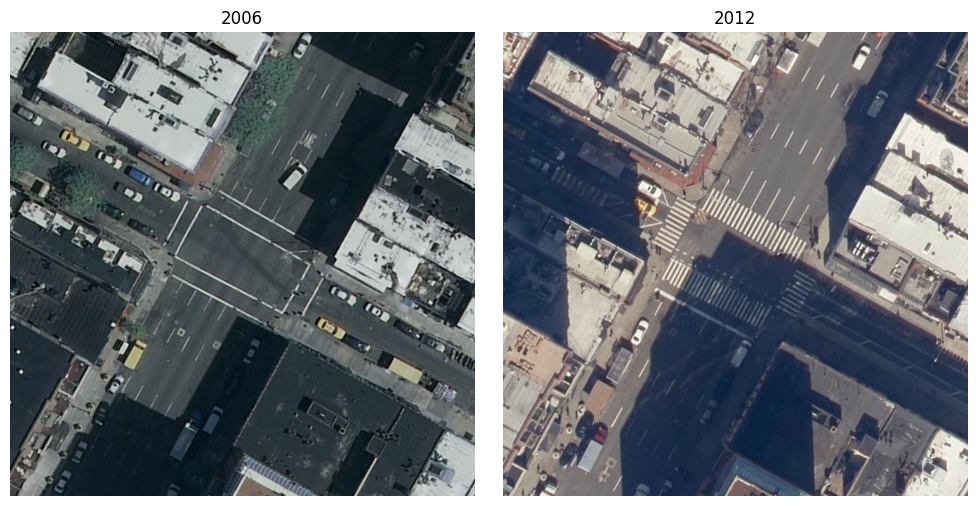

In [219]:
locations_to_year_files = locations.merge(
    location_year_files,
    on='location_id',
).set_index(['location_id', 'year'])


9056125
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_side_by_side(img1_path: str, img2_path: str, 
                      labels=("Left Image", "Right Image"), figsize=(10,5)):
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    for ax, img_path, label in zip(axes, [img1_path, img2_path], labels):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(label, fontsize=12)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
#show_side_by_side("image1.png", "image2.png", labels=("Before", "After"))


from PIL import Image
from st_preprocessing.config import DATA_PATH
# 71st and Broadway
# show_side_by_side(
#     DATA_PATH / locations_to_year_files.loc[9056125, '2006']['imagery_path'],
#     DATA_PATH / locations_to_year_files.loc[9056125, '2012']['imagery_path'],
#     labels=("2006", "2012")
# )

# Times Square - hard to see
# show_side_by_side(
#     DATA_PATH / locations_to_year_files.loc[21407, '2006']['imagery_path'],
#     DATA_PATH / locations_to_year_files.loc[21407, '2024']['imagery_path'],
#     labels=("2006", "2012")
# )

# Bowery 21008
show_side_by_side(
    DATA_PATH / locations_to_year_files.loc[21008, '2006']['imagery_path'],
    DATA_PATH / locations_to_year_files.loc[21008, '2024']['imagery_path'],
    labels=("2006", "2012")
)